Sample name: Cars2.png
Sample Image Shape: <PIL.Image.Image image mode=RGB size=400x400 at 0x7C5BF561A410>
Sample Bounding Box: tensor([[229., 176., 270., 193.]])
Sample Label: ['licence']


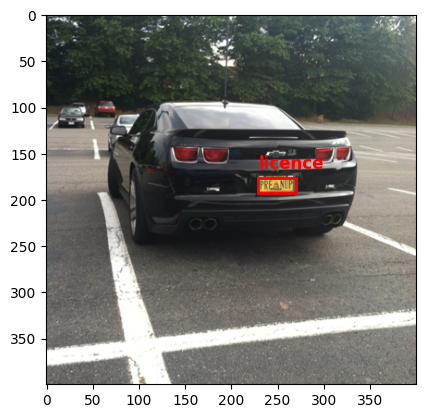

In [ ]:
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CarLicensePlateDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir) if f.endswith('.xml')]
        self.data = self._load_annotations()

    def _load_annotations(self):
        """Helper function to load all the annotations from XML files."""
        data = []

        for xml_file in self.xml_files:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            filename = root.find('filename').text
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            bboxes = []
            labels = []

            # Loop through each object in the XML file (multiple bounding boxes)
            for obj in root.findall('object'):
                label = obj.find('name').text  # Get label
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bboxes.append([xmin, ymin, xmax, ymax])  # Add bbox coordinates
                labels.append(label)  # Add label

            data.append({
                'filename': filename,
                'bboxes': torch.tensor(bboxes, dtype=torch.float32),
                'labels': labels,
                'size': [width, height]
            })

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data = self.data[idx]
        img_path = os.path.join(self.img_dir, img_data['filename'])
        image = Image.open(img_path).convert("RGB")
        bboxes = img_data['bboxes']
        labels = img_data['labels']

        if self.transform:
            image, bboxes = self.apply_transforms(image, bboxes, img_data['size'])

        return image, bboxes, labels, img_data['filename']

    def apply_transforms(self, image, bboxes, original_size):
        """Apply transformations to the image and adjust the bounding boxes accordingly."""
        width, height = original_size

        if isinstance(self.transform, transforms.Compose):
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    new_size = t.size
                    bboxes = self.resize_bbox(bboxes, (width, height), new_size)
                elif isinstance(t, transforms.RandomHorizontalFlip):
                    if random.random() < 0.5:  # Horizontal flip with 50% chance
                        image = F.hflip(image)
                        bboxes = self.flip_bbox_horizontal(bboxes, width)

        transformed_image = self.transform(image)
        return transformed_image, bboxes

    def resize_bbox(self, bboxes, original_size, new_size):
        """Resize bounding boxes according to the new image size."""
        original_w, original_h = original_size
        new_w, new_h = new_size

        scale_x = new_w / original_w
        scale_y = new_h / original_h

        bboxes[:, [0, 2]] *= scale_x  # Scale xmin and xmax
        bboxes[:, [1, 3]] *= scale_y  # Scale ymin and ymax

        return bboxes

    def flip_bbox_horizontal(self, bboxes, image_width):
        """Flip bounding boxes horizontally."""
        bboxes[:, [0, 2]] = image_width - bboxes[:, [2, 0]]  # Flip xmin and xmax
        return bboxes

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
# Directory where XML files are stored
annotations_dir = '/content/'

# Directory where images are stored
img_dir = '/content/'

#Define image transformations (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor()  # Convert images to tensors
])

# Create the dataset
car_dataset = CarLicensePlateDataset(annotations_dir=annotations_dir, img_dir=img_dir)


# Test loading a sample from the dataset
sample_image, sample_bbox, sample_label,sample_filename = car_dataset[0]
print("Sample name:", sample_filename)
print("Sample Image Shape:", sample_image)
print("Sample Bounding Box:", sample_bbox)
print("Sample Label:", sample_label)

# Convert the image tensor back to a NumPy array for visualization (if needed)
if isinstance(sample_image, torch.Tensor):
    sample_image = sample_image.permute(1, 2, 0).numpy()  # Convert from C x H x W to H x W x C

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(sample_image)



# Loop through the bounding boxes and draw each one
for bbox, label in zip(sample_bbox, sample_label):
    xmin, ymin, xmax, ymax = bbox

    # Calculate width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin



# Create a rectangle patch and add it to the axis
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 10, label, color='red', fontsize=12, weight='bold')

# Show the plot with the bounding box
plt.show()

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def collate_fn(batch):
    """
    Custom collate function for handling variable-length bounding boxes and labels.

    Args:
        batch: A list of tuples (image, bboxes, labels, filename) where:
            - image: Tensor of shape (C, H, W)
            - bboxes: Tensor of shape (num_boxes, 4)
            - labels: List of labels corresponding to each bounding box
            - filename: String representing the image file name

    Returns:
        Tuple containing:
        - images: Tensor of shape (batch_size, C, H, W)
        - bboxes: List of bounding box tensors, where each element is a tensor of shape (num_boxes, 4)
        - labels: List of labels, where each element is a list of strings
        - filenames: List of filenames
    """
    images = []
    bboxes = []
    labels = []
    filenames = []

    # Unpack each item in the batch and append it to the respective list
    for item in batch:
        images.append(item[0])       # Image tensor
        bboxes.append(item[1])       # Bounding boxes tensor
        labels.append(item[2])       # Labels list
        filenames.append(item[3])    # Filename string

    # Stack the images into a single tensor (batch_size, C, H, W)
    images = torch.stack(images, dim=0)

    return images, bboxes, labels, filenames

# Directories for XML annotations and images
annotations_dir = '/content/'
img_dir = '/content/'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor()  # Convert images to tensors
])

# Dataset
car_dataset = CarLicensePlateDataset(annotations_dir='/content/', img_dir='/content/')

# Dataloader
data_loader = DataLoader(dataset=car_dataset, batch_size=64, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
import numpy as np
plate_erea = []
aspect_ratios = []
bbox_counts = []
plate_area=[]
image_sizes = []

for image, bboxes, _, _ in data_loader:
    width_image, height_image = image.shape[0], image.shape[1]
    image_sizes.append((width_image, height_image))
    for bbox_list in bboxes:
        bbox_counts.append(len(bbox_list))
        for bbox in bbox_list:
            width = bbox[2] - bbox[0]
            height = bbox[3] - bbox[1]
            aspect_ratios.append(width / height)
            plate_area.append(width*height)


# Plot histogram of aspect ratios
plt.hist(aspect_ratios, bins=30)
plt.title('Bounding Box Aspect Ratios')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.show()

# Plot histogram of Plate erea
plt.hist(plate_area, bins=30)
plt.title('Bounding Box Erea')
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')
plt.show()

# Plot histogram of bounding box counts
plt.hist(bbox_counts, bins=range(1, max(bbox_counts)+2))
plt.title('Number of Bounding Boxes per Image')
plt.xlabel('Bounding Box Count')
plt.ylabel('Frequency')
plt.show()

widths, heights = zip(*image_sizes)

# Scatter plot of image dimensions
plt.scatter(widths, heights)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
image_sizes = []
for _, bboxes, _, filenames in data_loader:
    for i, filename in enumerate(filenames):
        image = Image.open(os.path.join(img_dir, filename))
        width, height = image.size
        image_sizes.append((width, height))

widths, heights = zip(*image_sizes)

# Scatter plot of image dimensions
plt.scatter(widths, heights)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

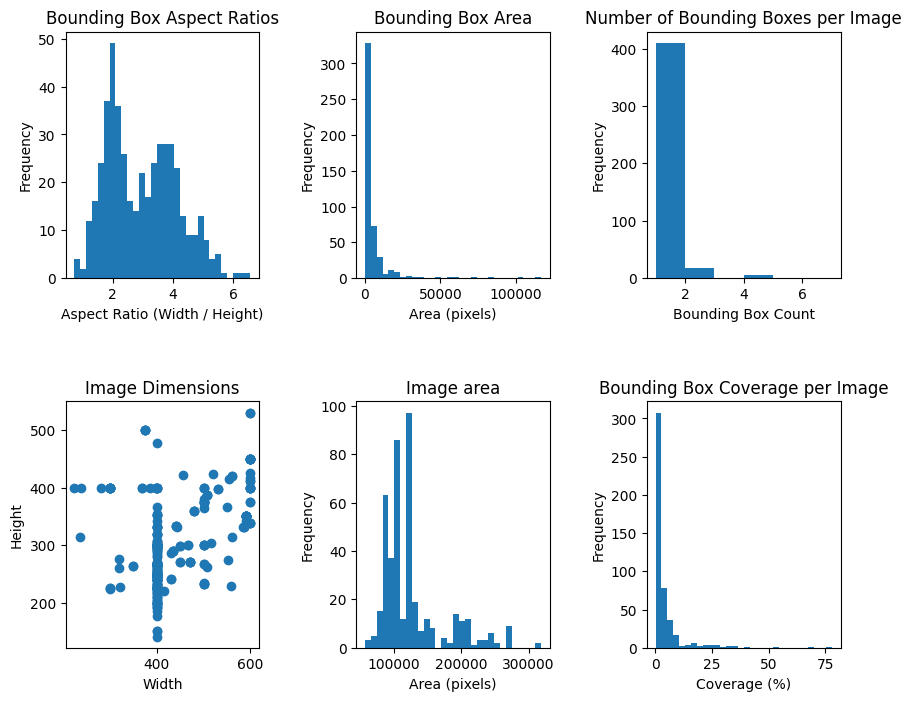

In [ ]:
import numpy as np
plate_erea = []
aspect_ratios = []
bbox_counts = []
plate_area=[]
image_sizes = []
image_area= []
bbox_coverage = []
for image, bboxes, _, filename in car_dataset:
    width_image, height_image = image.size
    image_sizes.append((width_image, height_image))
    bbox_counts.append(len(bboxes))
    image_area.append(width_image * height_image)
    for bbox in bboxes:
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        aspect_ratios.append(width / height)
        plate_area.append(width*height)
        bbox_coverage.append( (plate_area[-1]/image_area[-1])*100)

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
# Plot histogram of aspect ratios
axs[0, 0].hist(aspect_ratios, bins=30)
axs[0, 0].set_title('Bounding Box Aspect Ratios')
axs[0, 0].set_xlabel('Aspect Ratio (Width / Height)')
axs[0, 0].set_ylabel('Frequency')


# # Plot histogram of Plate erea
axs[0, 1].hist(plate_area, bins=30)
axs[0, 1].set_title('Bounding Box Area')
axs[0, 1].set_xlabel('Area (pixels)')
axs[0, 1].set_ylabel('Frequency')


# # Plot histogram of bounding box counts
axs[0, 2].hist(bbox_counts, bins=range(1, max(bbox_counts)+2))
axs[0, 2].set_title('Number of Bounding Boxes per Image')
axs[0, 2].set_xlabel('Bounding Box Count')
axs[0, 2].set_ylabel('Frequency')

widths, heights = zip(*image_sizes)

# # Scatter plot of image dimensions
axs[1, 0].scatter(widths, heights)
axs[1, 0].set_title('Image Dimensions')
axs[1, 0].set_xlabel('Width')
axs[1, 0].set_ylabel('Height')

# # Plot histogram of image erea
axs[1, 1].hist(image_area, bins=30)
axs[1, 1].set_title('Image area')
axs[1, 1].set_xlabel('Area (pixels)')
axs[1, 1].set_ylabel('Frequency')


axs[1, 2].hist(bbox_coverage, bins=30)
axs[1, 2].set_title('Bounding Box Coverage per Image')
axs[1, 2].set_xlabel('Coverage (%)')
axs[1, 2].set_ylabel('Frequency')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

<ipython-input-75-2f1516a922a6>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_centers, y=y_centers, cmap='Reds', shade=True, bw_adjust=0.5,cbar=True)


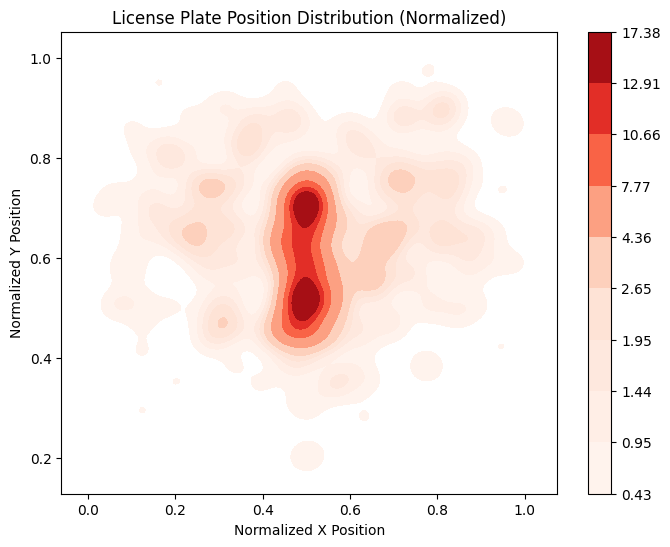

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x_centers = []
y_centers = []

for image, bboxes, _, filename in car_dataset:
     for bbox in bboxes:
            width_image, height_image = image.size
            xmin, ymin, xmax, ymax = bbox
            x_center = (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2
            x_centers.append(x_center.numpy() / width_image)  # Normalize by image width
            y_centers.append(y_center.numpy() / height_image)  # Normalize by image height

# Plot a heatmap of license plate positions

plt.figure(figsize=(8, 6))
sns.kdeplot(x=x_centers, y=y_centers, cmap='Reds', shade=True, bw_adjust=0.5,cbar=True)
plt.title('License Plate Position Distribution (Normalized)')
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.show()
